Calculating...
=== Generation:0===
=== Generation:1===
=== Generation:2===
=== Generation:3===
=== Generation:4===
=== Generation:5===
=== Generation:6===
=== Generation:7===
=== Generation:8===
=== Generation:9===
=== Generation:10===
=== Generation:11===
=== Generation:12===
=== Generation:13===
=== Generation:14===
=== Generation:15===
=== Generation:16===
=== Generation:17===
=== Generation:18===
=== Generation:19===
=== Generation:20===
=== Generation:21===
=== Generation:22===
=== Generation:23===
=== Generation:24===
=== Generation:25===
=== Generation:26===
=== Generation:27===
=== Generation:28===
=== Generation:29===
=== Generation:30===
=== Generation:31===
=== Generation:32===
=== Generation:33===
=== Generation:34===
=== Generation:35===
=== Generation:36===
=== Generation:37===
=== Generation:38===
=== Generation:39===
=== Generation:40===
=== Generation:41===
=== Generation:42===
=== Generation:43===
=== Generation:44===
=== Generation:45===
=== Generation:46===
=== Gene

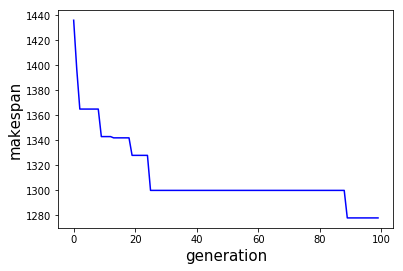

In [12]:
"""
===== Original Version Code: https://github.com/wurmen/Genetic-Algorithm-for-Job-Shop-Scheduling-and-NSGA-II/blob/master/implementation%20with%20python/GA-jobshop/GA_jobshop_makespan.py
===== Original Author's Information =====
Original Author: cheng-man wu
LinkedIn: www.linkedin.com/in/chengmanwu
Github: https://github.com/wurmen
=====
===== Adaptor: James, NTUST-IM
"""
import numpy as np
import pandas as pd
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import datetime
import copy
import time
import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

class Scheduler:
    def __init__(self):
        # Initial基本參數
        self.__parameters = {
            # Table
            "processTimeTable": None,
            "machinesSequenceTable": None,
            # basic parameters
            "populationSize": 30,
            "crossoverRate": 0.8,
            "mutationRate": 0.2,
            "mutationSelectionRate": 0.2,
            "maxGeneration": 100,
        }
        
    # -
    def Scheduler(self):
        print("Construct Initial Scheduler")
        
    # -
    def Scheduler(self, processTimeTableName, machinesSequenceTableName):
        # read table
        self.__parameters["processTimeTable"] = pd.read_csv(processTimeTableName)
        self.__parameters["machinesSequenceTable"] = pd.read_csv(machinesSequenceTableName)        
        
    # Accessor，Operator [] overloading
    def __getitem__(self, preferParameter):
        return self.__parameters[preferParameter]
    
    # Mutator，Operator [] overloading
    def __setitem__(self, preferParameter, preferValue):
        # 如果要設定的是Table，則利用該TableName讀取Table，再進行assign
        if(preferParameter == "processTimeTable"):
            self.__parameters["processTimeTable"] = pd.read_csv(preferValue, index_col=[0])
        elif(preferParameter == "machinesSequenceTable"):
            self.__parameters["machinesSequenceTable"] = pd.read_csv(preferValue, index_col=[0])
        # 一般數執行參數則直接assign
        else:
            self.__parameters[preferParameter] = preferValue
    
    # 印出所有參數
    def PrintAllParameters(self):
        print("Current Parameters List\n------")
        print(pd.Series(self.__parameters))
    
    # 啟動函式，變數名稱原則沿用原版本
    def Run(self):
        print("Calculating...")
        
        self.__dfshape=self.__parameters["processTimeTable"].shape
        self.__num_mc=self.__dfshape[1] # number of machines
        self.__num_job=self.__dfshape[0] # number of jobs
        self.__num_gene=self.__num_mc*self.__num_job # number of genes in a chromosome
        self.__num_mutation_jobs=round(self.__num_gene*self.__parameters["mutationSelectionRate"])
        
        self.__pt=[list(map(int, self.__parameters["processTimeTable"].iloc[i])) for i in range(self.__num_job)]
        self.__ms=[list(map(int, self.__parameters["machinesSequenceTable"].iloc[i])) for i in range(self.__num_job)]
        
        self.__Tbest=999999999999999
        self.__best_list, self.__best_obj=[],[]
        self.__population_list=[]
        self.__makespan_record=[]
        
        for t in range(self.__parameters["populationSize"]):
            #---產生初始群體---
            self.NewPupulation(t)
            #---
            
        for n in range(self.__parameters["maxGeneration"]):
            #---產生新群體---
            print("=== Generation:" + str(n) + "===")
            self.ReProduction()
            #---
            self.Repair()
            self.Mutation()
            self.CalcFitness()
            self.Selection()
            self.Compare()
            
    
    def NewPupulation(self, i):
        # 產生初始群體
        self.__nxm_random_num=list(np.random.permutation(self.__num_gene)) # generate a random permutation of 0 to self.__num_job*num_mc-1
        self.__population_list.append(self.__nxm_random_num)
        for j in range(self.__num_gene):
            self.__population_list[i][j]=self.__population_list[i][j]%self.__num_job # convert to job number format, every job appears m times
        
    def ReProduction(self):
        # 產生新群體
        self.__Tbest_now=99999999999
        #--- two point crossover ---
        self.__parent_list=copy.deepcopy(self.__population_list)
        self.__offspring_list=copy.deepcopy(self.__population_list)
        S=list(np.random.permutation(self.__parameters["populationSize"])) # generate a random sequence to select the parent chromosome to crossover

        for m in range(int(self.__parameters["populationSize"]/2)):
            crossover_prob=np.random.rand()
            if(crossover_prob <= self.__parameters["crossoverRate"]):
                parent_1= self.__population_list[S[2*m]][:]
                parent_2= self.__population_list[S[2*m+1]][:]
                child_1=parent_1[:]
                child_2=parent_2[:]
                cutpoint=list(np.random.choice(self.__num_gene, 2, replace=False))
                cutpoint.sort()

                child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
                child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
                self.__offspring_list[S[2*m]]=child_1[:]
                self.__offspring_list[S[2*m+1]]=child_2[:]        
        
    def Selection(self):
        # 選擇
        pk,qk=[],[]
    
        for i in range(self.__parameters["populationSize"]*2):
            pk.append(self.__chrom_fitness[i]/self.__total_fitness)
        for i in range(self.__parameters["populationSize"]*2):
            cumulative=0
            for j in range(0,i+1):
                cumulative=cumulative+pk[j]
            qk.append(cumulative)

        selection_rand=[np.random.rand() for i in range(self.__parameters["populationSize"])]

        for i in range(self.__parameters["populationSize"]):
            if selection_rand[i]<=qk[0]:
                self.__population_list[i]=copy.deepcopy(self.__total_chromosome[0])
            else:
                for j in range(0,self.__parameters["populationSize"]*2-1):
                    if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                        self.__population_list[i]=copy.deepcopy(self.__total_chromosome[j+1])
                        break

    '''
    def Crossover(self):
        # 交配
    '''

    def Mutation(self):
        # 突變
        for m in range(len(self.__offspring_list)):
            mutation_prob=np.random.rand()
            if(mutation_prob <= self.__parameters["mutationRate"]):
                m_chg=list(np.random.choice(self.__num_gene, self.__num_mutation_jobs, replace=False)) # chooses the position to mutation
                t_value_last=self.__offspring_list[m][m_chg[0]] # save the value which is on the first mutation position
                for i in range(self.__num_mutation_jobs-1):
                    self.__offspring_list[m][m_chg[i]]=self.__offspring_list[m][m_chg[i+1]] # displacement

                self.__offspring_list[m][m_chg[self.__num_mutation_jobs-1]]=t_value_last # move the value of the first mutation position to the last mutation position


    def Repair(self):
        # 修復
        for m in range(self.__parameters["populationSize"]):
            job_count={}
            larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
            for i in range(self.__num_job):
                if i in self.__offspring_list[m]:
                    count=self.__offspring_list[m].count(i)
                    pos=self.__offspring_list[m].index(i)
                    job_count[i]=[count,pos] # store the above two values to the job_count dictionary
                else:
                    count=0
                    job_count[i]=[count,0]
                if count>self.__num_mc:
                    larger.append(i)
                elif count<self.__num_mc:
                    less.append(i)

            for k in range(len(larger)):
                chg_job=larger[k]
                while job_count[chg_job][0] > self.__num_mc:
                    for d in range(len(less)):
                        if job_count[less[d]][0] < self.__num_mc:                    
                            self.__offspring_list[m][job_count[chg_job][1]]=less[d]
                            job_count[chg_job][1]=self.__offspring_list[m].index(chg_job)
                            job_count[chg_job][0]=job_count[chg_job][0]-1
                            job_count[less[d]][0]=job_count[less[d]][0]+1                    
                        if job_count[chg_job][0]==self.__num_mc:
                            break

    
    
    def CalcFitness(self):
        # 計算適應值
        self.__total_chromosome=copy.deepcopy(self.__parent_list)+copy.deepcopy(self.__offspring_list) # parent and offspring chromosomes combination
        self.__chrom_fitness,self.__chrom_fit=[],[]
        self.__total_fitness=0
        for m in range(self.__parameters["populationSize"]*2):
            j_keys=[j for j in range(self.__num_job)]
            key_count={key:0 for key in j_keys}
            j_count={key:0 for key in j_keys}
            m_keys=[j+1 for j in range(self.__num_mc)]
            m_count={key:0 for key in m_keys}

            for i in self.__total_chromosome[m]:
                gen_t=int(self.__pt[i][key_count[i]])
                gen_m=int(self.__ms[i][key_count[i]])
                j_count[i]=j_count[i]+gen_t
                m_count[gen_m]=m_count[gen_m]+gen_t

                if m_count[gen_m]<j_count[i]:
                    m_count[gen_m]=j_count[i]
                elif m_count[gen_m]>j_count[i]:
                    j_count[i]=m_count[gen_m]

                key_count[i]=key_count[i]+1

            makespan=max(j_count.values())
            self.__chrom_fitness.append(1/makespan)
            self.__chrom_fit.append(makespan)
            self.__total_fitness=self.__total_fitness+self.__chrom_fitness[m]

    def Compare(self):
        # 比較
        for i in range(self.__parameters["populationSize"]*2):
            if self.__chrom_fit[i]<self.__Tbest_now:
                self.__Tbest_now=self.__chrom_fit[i]
                sequence_now=copy.deepcopy(self.__total_chromosome[i])
        if self.__Tbest_now<=self.__Tbest:
            self.__Tbest=self.__Tbest_now
            self.__sequence_best=copy.deepcopy(sequence_now)
        
        self.__makespan_record.append(self.__Tbest)
    
    def PrintResult(self):
        # 印出計算結果
        print("optimal sequence",self.__sequence_best)
        print("optimal value:%f"%self.__Tbest)

    def PrintFitnessPlot(self):
        # 繪製適應度趨勢圖
        plt.plot([i for i in range(len(self.__makespan_record))],self.__makespan_record,'b')
        plt.ylabel('makespan',fontsize=15)
        plt.xlabel('generation',fontsize=15)
        plt.show()

    def GenerateGanttChart(self):
        # 繪製甘特圖
        m_keys=[j+1 for j in range(self.__num_mc)]
        j_keys=[j for j in range(self.__num_job)]
        key_count={key:0 for key in j_keys}
        j_count={key:0 for key in j_keys}
        m_count={key:0 for key in m_keys}
        j_record={}
        for i in self.__sequence_best:
            gen_t=int(self.__pt[i][key_count[i]])
            gen_m=int(self.__ms[i][key_count[i]])
            j_count[i]=j_count[i]+gen_t
            m_count[gen_m]=m_count[gen_m]+gen_t

            if m_count[gen_m]<j_count[i]:
                m_count[gen_m]=j_count[i]
            elif m_count[gen_m]>j_count[i]:
                j_count[i]=m_count[gen_m]

            start_time=str(datetime.timedelta(seconds=j_count[i]-self.__pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
            end_time=str(datetime.timedelta(seconds=j_count[i]))

            j_record[(i,gen_m)]=[start_time,end_time]

            key_count[i]=key_count[i]+1


        df=[]
        for m in m_keys:
            for j in j_keys:
                df.append(dict(Task='Machine %s'%(m), Start='2018-07-14 %s'%(str(j_record[(j,m)][0])), Finish='2018-07-14 %s'%(str(j_record[(j,m)][1])),Resource='Job %s'%(j+1)))
                
        fig = ff.create_gantt(df, index_col='Resource', show_colorbar=True, group_tasks=True, showgrid_x=True, title='Job shop Schedule')
        iplot(fig, filename='GA_job_shop_scheduling')
        